In [18]:
%pip install -q h5py pandas matplotlib opencv-python torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import glob
import gc
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import h5py
import cv2
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (8, 6)

# Global configuration
N_BANDS_HSI = 61

# Target resolution for each modality
HSI_TARGET_H, HSI_TARGET_W = 1024, 1024   # HSI: 1024x1024x61
RGB_TARGET_H, RGB_TARGET_W = 512, 512     # RGB:  512x512x3

# GPU configuration (PyTorch)
try:
    import torch
    import torch.nn.functional as F

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # if your GPU is not compatible (or if you want to use CPU), comment the line above and uncomment the line below
    # DEVICE = torch.device("cpu")
except Exception:
    torch = None
    F = None
    DEVICE = None

USE_GPU_INTERP = (torch is not None) and (DEVICE.type == "cuda")
USE_GPU_RESIZE = False  # set True to resize HSI/RGB on GPU (can require more VRAM)

In [26]:
def load_hsi_cube(path: str) -> np.ndarray:
    """Load HSI cube (expected: H,W,61) from an .h5 file."""
    try:
        with h5py.File(path, "r") as f:
            if "cube" in f:
                data = f["cube"][:]
            else:
                keys = list(f.keys())
                if len(keys) == 0:
                    raise ValueError(f"H5 file has no datasets: {path}")
                data = f[keys[0]][:]
    except OSError as e:
        raise OSError(f"Error reading H5: {path}\n{e}")

    if data.ndim != 3 or data.shape[-1] != N_BANDS_HSI:
        raise ValueError(f"Expected (H, W, {N_BANDS_HSI}), got {data.shape} in {path}")

    return data.astype(np.float32, copy=False)

def ensure_hsi_size(cube: np.ndarray, target_h: int, target_w: int,
                    use_gpu: bool = USE_GPU_RESIZE) -> np.ndarray:
    """Ensure HSI is target_h x target_w x 61 (resize if needed)."""
    h, w, b = cube.shape
    if (h, w) == (target_h, target_w):
        return cube

    if use_gpu and (torch is not None) and (F is not None) and (DEVICE is not None):
        # H,W,C -> 1,C,H,W
        t = torch.from_numpy(cube).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
        t = F.interpolate(t, size=(target_h, target_w), mode="bilinear", align_corners=False)
        out = t.squeeze(0).permute(1, 2, 0).contiguous().cpu().numpy()
        return out.astype(np.float32, copy=False)

    # CPU fallback (OpenCV, per-band)
    bands = []
    for i in range(b):
        band = cube[:, :, i]
        band_resized = cv2.resize(band, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        bands.append(band_resized)
    return np.stack(bands, axis=-1).astype(np.float32, copy=False)

def ensure_rgb_size(rgb: np.ndarray, target_h: int, target_w: int,
                    use_gpu: bool = USE_GPU_RESIZE) -> np.ndarray:
    """Ensure RGB is target_h x target_w x 3 (resize if needed)."""
    h, w, c = rgb.shape
    if (h, w) == (target_h, target_w):
        return rgb

    if use_gpu and (torch is not None) and (F is not None) and (DEVICE is not None):
        # H,W,C -> 1,C,H,W
        t = torch.from_numpy(rgb).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
        t = F.interpolate(t, size=(target_h, target_w), mode="bilinear", align_corners=False)
        out = t.squeeze(0).permute(1, 2, 0).contiguous().cpu().numpy()
        return out.astype(np.float32, copy=False)

    return cv2.resize(rgb, (target_w, target_h), interpolation=cv2.INTER_LINEAR)

def hsi_false_color(hsi_cube: np.ndarray) -> np.ndarray:
    """Create a false-color RGB visualization from 3 HSI bands."""
    b1, b2, b3 = 0, N_BANDS_HSI // 2, N_BANDS_HSI - 1
    rgb = np.stack([hsi_cube[..., b1], hsi_cube[..., b2], hsi_cube[..., b3]], axis=-1)
    rgb = rgb - rgb.min()
    m = rgb.max()
    if m > 0:
        rgb = rgb / m
    return rgb

def smote_interpolate_pair(hsi1: np.ndarray, rgb1: np.ndarray,
                           hsi2: np.ndarray, rgb2: np.ndarray,
                           lam: float | None = None,
                           use_gpu: bool = USE_GPU_INTERP) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Linear interpolation (SMOTE-like) between two HSI+RGB pairs:

      x_syn = x1 + lam * (x2 - x1),  lam ~ U(0,1)

    HSI and RGB are interpolated separately.
    """
    if lam is None:
        lam = float(np.random.rand())

    if use_gpu and (torch is not None) and (DEVICE is not None):
        lam_t = torch.tensor(lam, device=DEVICE, dtype=torch.float32)

        h1 = torch.from_numpy(hsi1).to(DEVICE)
        h2 = torch.from_numpy(hsi2).to(DEVICE)
        r1 = torch.from_numpy(rgb1).to(DEVICE)
        r2 = torch.from_numpy(rgb2).to(DEVICE)

        h_syn = h1 + lam_t * (h2 - h1)
        r_syn = r1 + lam_t * (r2 - r1)

        return h_syn.detach().cpu().numpy(), r_syn.detach().cpu().numpy(), lam

    hsi_syn = hsi1 + lam * (hsi2 - hsi1)
    rgb_syn = rgb1 + lam * (rgb2 - rgb1)
    return hsi_syn, rgb_syn, lam

In [ ]:
# Put your data path below
BASE_TRAIN_DIR = r"/path/to/track2/train"
BASE_TEST_DIR  = r"/path/to/track2/test-public"

# Output root for Data Augmentation (local)
OUT_ROOT_DA = r"./DataAugmentation"

OUT_TRAIN_HSI = os.path.join(OUT_ROOT_DA, "train", "hsi_61")
OUT_TRAIN_RGB = os.path.join(OUT_ROOT_DA, "train", "rgb_2")
OUT_TEST_HSI  = os.path.join(OUT_ROOT_DA, "test-public", "hsi_61")
OUT_TEST_RGB  = os.path.join(OUT_ROOT_DA, "test-public", "rgb_2")

for d in [OUT_TRAIN_HSI, OUT_TRAIN_RGB, OUT_TEST_HSI, OUT_TEST_RGB]:
    os.makedirs(d, exist_ok=True)

print("BASE_TRAIN_DIR:", BASE_TRAIN_DIR)
print("BASE_TEST_DIR :", BASE_TEST_DIR)
print("OUT_ROOT_DA   :", OUT_ROOT_DA)
print("GPU device    :", DEVICE if DEVICE is not None else "torch not available")
print("USE_GPU_INTERP:", USE_GPU_INTERP, "| USE_GPU_RESIZE:", USE_GPU_RESIZE)

def ensure_local_copy(src_dir: str, dst_dir: str) -> None:
    """
    Optional helper: copy a dataset folder to a local, stable path (useful for HDF5).
    If dst_dir exists and is not empty, it is reused.
    """
    src = Path(src_dir)
    dst = Path(dst_dir)

    if dst.exists() and any(dst.iterdir()):
        print(f"Local folder exists and is not empty: {dst}")
        print("-> Reusing existing copy.")
        return

    print(f"Copying data from {src} to {dst} ...")
    if dst.exists():
        shutil.rmtree(dst)
    dst.mkdir(parents=True, exist_ok=True)

    # Copy contents of src_dir into dst_dir
    for item in src.iterdir():
        if item.is_dir():
            shutil.copytree(item, dst / item.name)
        else:
            shutil.copy2(item, dst / item.name)

    print("Copy completed.")

BASE_TRAIN_DIR: ../../data_challenge/track2/train
BASE_TEST_DIR : ../../data_challenge/track2/test-public
OUT_ROOT_DA   : ./DataAugmentation
GPU device    : cpu
USE_GPU_INTERP: False | USE_GPU_RESIZE: False


In [28]:
def build_labels_df(base_dir: str, split_name: str) -> pd.DataFrame:
    """
    Read hsi_61/*.h5 and find the RGB pair in rgb_2 with the same basename.
    Extract:
      - id (e.g., Category-1_a_0000)
      - category_name (e.g., Category-1)
      - label (e.g., 1)
      - relative paths to files
    """
    hsi_dir = os.path.join(base_dir, "hsi_61")
    rgb_dir = os.path.join(base_dir, "rgb_2")

    hsi_paths = sorted(glob.glob(os.path.join(hsi_dir, "*.h5")))
    rows = []
    missing_rgb = 0

    for hsi_path in hsi_paths:
        base = os.path.splitext(os.path.basename(hsi_path))[0]
        rgb_path = None

        for ext in ["png", "jpg", "jpeg", "tif", "tiff"]:
            cand = os.path.join(rgb_dir, f"{base}.{ext}")
            if os.path.exists(cand):
                rgb_path = cand
                break

        if rgb_path is None:
            missing_rgb += 1
            continue

        first_token = base.split("_")[0]  # "Category-1"
        category_name = first_token
        try:
            label_num = int(category_name.split("-")[-1])
        except Exception:
            label_num = -1

        rows.append({
            "split": split_name,
            "id": base,
            "category_name": category_name,
            "label": label_num,
            "hsi_relpath": os.path.relpath(hsi_path, base_dir),
            "rgb_relpath": os.path.relpath(rgb_path, base_dir),
        })

    df = pd.DataFrame(rows)
    print(f"{split_name}: {len(df)} HSI+RGB pairs; {missing_rgb} HSI files without RGB.")
    print("Label distribution:")
    print(df["label"].value_counts().sort_index())
    return df

labels_train = build_labels_df(BASE_TRAIN_DIR, "train")
labels_test  = build_labels_df(BASE_TEST_DIR,  "test-public")

print("\nLabel distribution (train):")
print(labels_train["label"].value_counts().sort_index())
print("\nLabel distribution (test-public):")
print(labels_test["label"].value_counts().sort_index())


# Save metadata
os.makedirs(OUT_ROOT_DA, exist_ok=True)
LABELS_TRAIN_CSV = os.path.join(OUT_ROOT_DA, "labels_train.csv")
LABELS_TEST_CSV  = os.path.join(OUT_ROOT_DA, "labels_test-public.csv")

labels_train.to_csv(LABELS_TRAIN_CSV, index=False)
labels_test.to_csv(LABELS_TEST_CSV,  index=False)

print("\nMetadata saved to:")
print(" ", LABELS_TRAIN_CSV)
print(" ", LABELS_TEST_CSV)

train: 167 HSI+RGB pairs; 0 HSI files without RGB.
Label distribution:
label
1    50
2    31
3    57
4    29
Name: count, dtype: int64
test-public: 11 HSI+RGB pairs; 0 HSI files without RGB.
Label distribution:
label
1    9
3    2
Name: count, dtype: int64

Label distribution (train):
label
1    50
2    31
3    57
4    29
Name: count, dtype: int64

Label distribution (test-public):
label
1    9
3    2
Name: count, dtype: int64

Metadata saved to:
  ./DataAugmentation/labels_train.csv
  ./DataAugmentation/labels_test-public.csv


In [29]:
# Create SMOTE plan to balance the 4 classes
def build_smote_plan_for_split(labels_df: pd.DataFrame,
                               split_name: str,
                               random_state: int = 42) -> pd.DataFrame:
    """
    Build a DataFrame with columns:
      split, label, id1, id2, synthetic_id

    After generating all synthetic samples in this plan, class counts
    should be balanced within the split.
    """
    rng = np.random.default_rng(random_state)

    labels_df = labels_df[labels_df["label"] >= 0].copy()
    class_counts = labels_df["label"].value_counts().sort_index()
    if class_counts.empty:
        raise ValueError(f"No valid classes found for split {split_name}.")

    print(f"\n==== {split_name}: current class counts ====")
    print(class_counts)

    max_count = int(class_counts.max())
    print(f"Most frequent class in {split_name}: {max_count} samples.")

    plan_rows = []

    for label, count in class_counts.items():
        needed = max_count - int(count)
        if needed <= 0:
            continue

        df_c = labels_df[labels_df["label"] == label]
        ids = df_c["id"].tolist()

        if len(ids) < 2:
            print(f"Warning: label {label} in split {split_name} has < 2 samples; cannot do SMOTE-like interpolation.")
            continue

        used_pairs = set()
        attempts = 0

        while needed > 0 and attempts < 10000:
            id1, id2 = rng.choice(ids, size=2, replace=False)
            pair_key = tuple(sorted((id1, id2)))
            if pair_key in used_pairs:
                attempts += 1
                continue

            used_pairs.add(pair_key)
            synthetic_id = f"{id1}_{id2}"
            plan_rows.append({
                "split": split_name,
                "label": int(label),
                "id1": id1,
                "id2": id2,
                "synthetic_id": synthetic_id,
            })
            needed -= 1
            attempts = 0

        if needed > 0:
            print(f"Warning: could not plan all synthetic samples for label {label} in {split_name}. Missing {needed}.")

    plan_df = pd.DataFrame(plan_rows)
    print(f"\nPlan for {split_name}: {len(plan_df)} synthetic samples to generate.")
    return plan_df

# Reload metadata from disk
labels_train = pd.read_csv(LABELS_TRAIN_CSV)
labels_test  = pd.read_csv(LABELS_TEST_CSV)

plan_train = build_smote_plan_for_split(labels_train, "train")
plan_test  = build_smote_plan_for_split(labels_test,  "test-public")


smote_plan = pd.concat([plan_train, plan_test], ignore_index=True)

SMOTE_PLAN_CSV = os.path.join(OUT_ROOT_DA, "smote_plan.csv")
smote_plan.to_csv(SMOTE_PLAN_CSV, index=False)

print("\nGlobal SMOTE plan saved to:")
print(" ", SMOTE_PLAN_CSV)

print("\nPlan summary (by split):")
print(smote_plan.groupby(["split", "label"]).size())


==== train: current class counts ====
label
1    50
2    31
3    57
4    29
Name: count, dtype: int64
Most frequent class in train: 57 samples.

Plan for train: 61 synthetic samples to generate.

==== test-public: current class counts ====
label
1    9
3    2
Name: count, dtype: int64
Most frequent class in test-public: 9 samples.

Plan for test-public: 1 synthetic samples to generate.

Global SMOTE plan saved to:
  ./DataAugmentation/smote_plan.csv

Plan summary (by split):
split        label
test-public  3         1
train        1         7
             2        26
             4        28
dtype: int64


In [30]:
# Generate one synthetic pair (HSI + RGB) per call
def generate_next_synthetic_from_plan(
    plan_path: str,
    labels_train_path: str,
    labels_test_path: str,
    base_train_dir: str,
    base_test_dir: str,
    out_root_da: str,
    split_filter: str | None = None,   # "train", "test-public", or None (both)
    show_plot: bool = True,
    use_gpu_interp: bool = USE_GPU_INTERP
) -> None:
    """
    Read smote_plan.csv, find the first row whose synthetic files do not exist,
    generate the interpolated HSI+RGB pair (SMOTE-like), and save it.

    Generates only ONE pair per call.
    """
    plan_df = pd.read_csv(plan_path)

    if split_filter is not None:
        plan_df = plan_df[plan_df["split"] == split_filter].copy()
        if plan_df.empty:
            print(f"No entries in the plan for split={split_filter}.")
            return

    labels_train = pd.read_csv(labels_train_path)
    labels_test  = pd.read_csv(labels_test_path)

    labels_by_split = {
        "train": labels_train,
        "test-public": labels_test,
    }
    base_by_split = {
        "train": base_train_dir,
        "test-public": base_test_dir,
    }

    # Ensure output directories exist
    out_dirs = {}
    for split in ["train", "test-public"]:
        out_hsi = os.path.join(out_root_da, split, "hsi_61")
        out_rgb = os.path.join(out_root_da, split, "rgb_2")
        os.makedirs(out_hsi, exist_ok=True)
        os.makedirs(out_rgb, exist_ok=True)
        out_dirs[split] = {"hsi": out_hsi, "rgb": out_rgb}

    # Find next pending entry
    for _, row in plan_df.iterrows():
        split = row["split"]
        synthetic_id = row["synthetic_id"]

        out_hsi_path = os.path.join(out_dirs[split]["hsi"], synthetic_id + ".h5")
        out_rgb_path = os.path.join(out_dirs[split]["rgb"], synthetic_id + ".png")

        if os.path.exists(out_hsi_path) and os.path.exists(out_rgb_path):
            continue

        labels_df = labels_by_split[split]
        base_dir  = base_by_split[split]

        id1 = row["id1"]
        id2 = row["id2"]

        row1 = labels_df[labels_df["id"] == id1]
        row2 = labels_df[labels_df["id"] == id2]
        if row1.empty or row2.empty:
            print(f"Warning: missing metadata for {id1} or {id2} in split {split}. Skipping.")
            continue

        row1 = row1.iloc[0]
        row2 = row2.iloc[0]

        hsi1_path = os.path.join(base_dir, row1["hsi_relpath"])
        rgb1_path = os.path.join(base_dir, row1["rgb_relpath"])
        hsi2_path = os.path.join(base_dir, row2["hsi_relpath"])
        rgb2_path = os.path.join(base_dir, row2["rgb_relpath"])

        # Load original HSI and RGB
        hsi1 = ensure_hsi_size(load_hsi_cube(hsi1_path), HSI_TARGET_H, HSI_TARGET_W)
        hsi1 = hsi1 - hsi1.min()
        m1 = hsi1.max()
        if m1 > 0:
            hsi1 = hsi1 / m1

        hsi2 = ensure_hsi_size(load_hsi_cube(hsi2_path), HSI_TARGET_H, HSI_TARGET_W)
        hsi2 = hsi2 - hsi2.min()
        m2 = hsi2.max()
        if m2 > 0:
            hsi2 = hsi2 / m2

        rgb1 = cv2.imread(rgb1_path, cv2.IMREAD_COLOR)
        if rgb1 is None:
            print(f"Failed to read RGB: {rgb1_path}")
            return
        rgb1 = cv2.cvtColor(rgb1, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        rgb1 = ensure_rgb_size(rgb1, RGB_TARGET_H, RGB_TARGET_W)

        rgb2 = cv2.imread(rgb2_path, cv2.IMREAD_COLOR)
        if rgb2 is None:
            print(f"Failed to read RGB: {rgb2_path}")
            return
        rgb2 = cv2.cvtColor(rgb2, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        rgb2 = ensure_rgb_size(rgb2, RGB_TARGET_H, RGB_TARGET_W)

        # SMOTE-like interpolation (optionally on GPU)
        hsi_syn, rgb_syn, lam = smote_interpolate_pair(hsi1, rgb1, hsi2, rgb2, use_gpu=use_gpu_interp)

        # Save synthetic HSI to .h5
        with h5py.File(out_hsi_path, "w") as f:
            f.create_dataset("cube", data=hsi_syn.astype(np.float32, copy=False))

        # Save synthetic RGB to .png
        rgb_uint8 = (np.clip(rgb_syn, 0.0, 1.0) * 255).astype(np.uint8)
        cv2.imwrite(out_rgb_path, cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2BGR))

        print(f"\nGenerated synthetic {synthetic_id}")
        print(f"  split = {split}, label = {row['label']}, lambda = {lam:.3f}")
        print(f"  HSI saved to: {out_hsi_path}")
        print(f"  RGB saved to: {out_rgb_path}")

        if show_plot:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title(f"{id1} (RGB)")
            plt.imshow(rgb1)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title(f"{id2} (RGB)")
            plt.imshow(rgb2)
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title(f"{synthetic_id} (SMOTE-like)")
            plt.imshow(rgb_syn)
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        # Cleanup
        del hsi1, hsi2, rgb1, rgb2, hsi_syn, rgb_syn
        gc.collect()
        return

    print("No pending entries in the plan (all synthetic samples were generated).")


Generated synthetic Category-1_a_0004_Category-1_a_0046
  split = train, label = 1, lambda = 0.994
  HSI saved to: ./DataAugmentation/train/hsi_61/Category-1_a_0004_Category-1_a_0046.h5
  RGB saved to: ./DataAugmentation/train/rgb_2/Category-1_a_0004_Category-1_a_0046.png


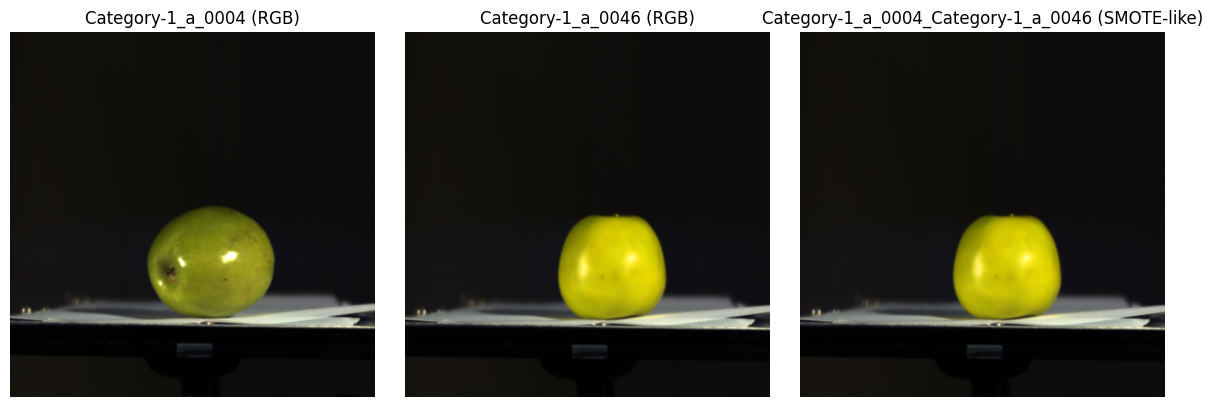

In [31]:
# Run this cell to generate 1 synthetic sample at a time

generate_next_synthetic_from_plan(
    plan_path=SMOTE_PLAN_CSV,
    labels_train_path=LABELS_TRAIN_CSV,
    labels_test_path=LABELS_TEST_CSV,
    base_train_dir=BASE_TRAIN_DIR,
    base_test_dir=BASE_TEST_DIR,
    out_root_da=OUT_ROOT_DA,
    split_filter=None,     # or "train" / "test-public"
    show_plot=True,
    use_gpu_interp=True
)